## Predicting with a Trained Model

In [5]:
import torch
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from main import CatDogDataModule, LitResNet
from models.resnet import ResNet18
import torch.nn.functional as F


class CatDogPredictor:
    """
    Class for making predictions on cat/dog images using a trained model.
    """

    def __init__(self, checkpoint_path, image_size=(64, 64)):
        """
        Initialize the predictor with a trained model checkpoint.

        Args:
            checkpoint_path (str): Path to the model checkpoint
            image_size (tuple): Size to resize input images to
        """
        # Load the trained model
        self.model = LitResNet.load_from_checkpoint(checkpoint_path)
        self.model.eval()
        self.model.freeze()

        # Move model to GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)

        # Define image transforms
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.Grayscale(1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.449], std=[0.226])
        ])

        # Class labels
        self.classes = ['Cat', 'Dog']

    def predict_image(self, image_path):
        """
        Make a prediction on a single image.

        Args:
            image_path (str): Path to the image file

        Returns:
            tuple: (predicted_class, confidence_score)
        """
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0)  # Add batch dimension
        image = image.to(self.device)

        # Make prediction
        with torch.no_grad():
            logits = self.model(image)
            probabilities = F.softmax(logits, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        return (
            self.classes[predicted.item()],
            confidence.item()
        )


def evaluate_model(checkpoint_path, data_module):
    """
    Evaluate the model on the test set and print detailed metrics.

    Args:
        checkpoint_path (str): Path to the model checkpoint
        data_module (CatDogDataModule): Data module containing the test dataset
    """
    # Load model from checkpoint
    model = LitResNet.load_from_checkpoint(checkpoint_path)

    # Initialize trainer for testing
    trainer = pl.Trainer(
        accelerator='auto',
        devices=1,
    )

    # Test the model and get metrics
    results = trainer.test(model, data_module)[0]

    # Print detailed results
    print("\nTest Set Evaluation Results:")
    print(f"Test Accuracy: {results['test_acc']:.4f}")
    print(f"Test Loss: {results['test_loss']:.4f}")

    return results

## Load image Cat image

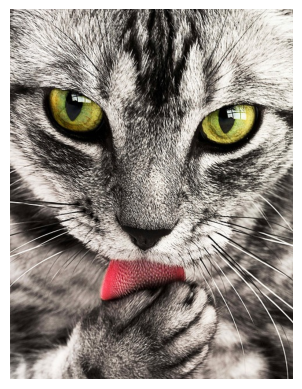

In [6]:

image_path = "./examples/cat.jpg"
image = Image.open(image_path)

#plot the imag
plt.imshow(image)
plt.axis('off')
plt.show()

In [13]:
# Create predictor instance
checkpoint_path = "saved_models/checkpoint.ckpt"
predictor = CatDogPredictor(checkpoint_path)

# Example: Predict single image
predicted_class, confidence = predictor.predict_image(image_path)
print(f"\nPrediction Results:")
print(f"Image: {image_path}")
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2%}")



Prediction Results:
Image: ./examples/dog.jpg
Predicted Class: Dog
Confidence: 97.52%


## Load image Dog image

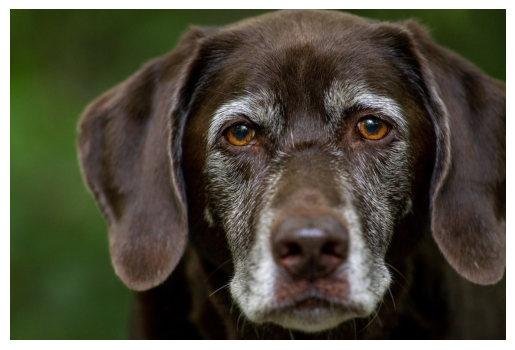

In [11]:
image_path = "./examples/dog.jpg"
image = Image.open(image_path)

#plot the imag
plt.imshow(image)
plt.axis('off')
plt.show()


In [14]:
    # Create predictor instance
checkpoint_path = "./saved_models/checkpoint.ckpt"
predictor = CatDogPredictor(checkpoint_path)

# Example: Predict single image
predicted_class, confidence = predictor.predict_image(image_path)
print(f"\nPrediction Results:")
print(f"Image: {image_path}")
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2%}")



Prediction Results:
Image: ./examples/dog.jpg
Predicted Class: Dog
Confidence: 97.52%
